In [1]:
from wflow_reservoirs import WflowReservoir
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

ImportError: cannot import name 'WflowReservoir' from 'wflow_reservoirs' (c:\Users\hartgrin\Miniconda3\envs\Wflow_Rur\lib\site-packages\wflow_reservoirs\__init__.py)

In [62]:
df = pd.read_csv('Olef.csv', index_col='time', parse_dates=True)
fractions = np.loadtxt('fractions.csv')

info = {
        "inflow"          :  df["Qin"],
        "demand"          : 0.3,
        "maxrelease"      : 4.5, 
        "maxvolume"       : 19200000.0,
        "initial_storage" : 12000000.0,
        "targetminfrac"   : fractions[0],
        "targetfullfrac"  : fractions[1],
        "csv_path"        : 'sq.csv'
}

In [63]:
olef_simple = WflowReservoir()
olef_simple.setup_simple(info["maxvolume"], info["maxrelease"], info["demand"], info["targetminfrac"], info["targetfullfrac"])
olef_simple.run(info["inflow"], info["initial_storage"])

In [64]:
olef_sqtable = WflowReservoir()
olef_sqtable.setup_sqtable(info["maxvolume"], info["csv_path"])
olef_sqtable.run(info["inflow"], info["initial_storage"])

In [65]:
def custom_function(time, inflow, storage, timestepsecs, maxvolume):
    outflow = 1.5 if time.dayofyear < 100 else 0.5
    storage = storage + inflow*timestepsecs - outflow*timestepsecs
    overflow = 0 if storage < maxvolume else storage-maxvolume
    return outflow + overflow/timestepsecs, min(storage, maxvolume)

olef_custom = WflowReservoir()
olef_custom.setup_custom(custom_function, info["maxvolume"])
olef_custom.run(info["inflow"], info["initial_storage"])

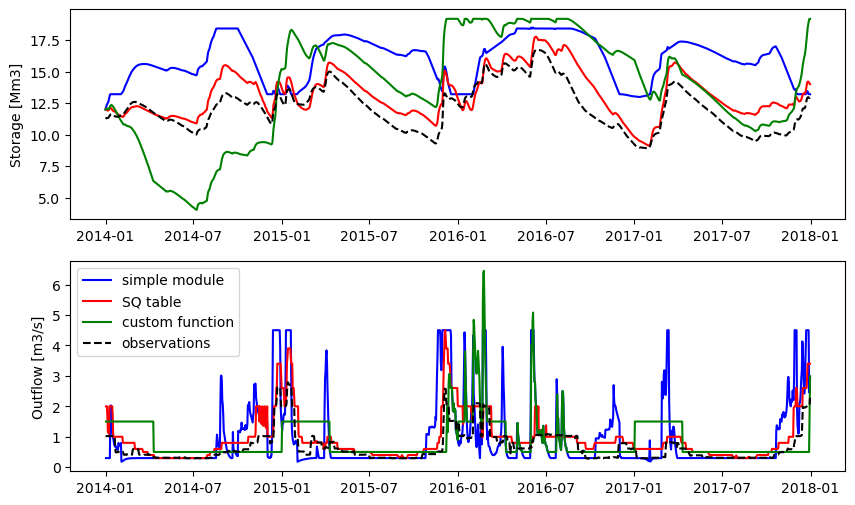

In [75]:
plt.figure(1, figsize=(10,6))
plt.subplot(211)
plt.plot(olef_simple.storage/1e6,'b')
plt.plot(olef_sqtable.storage/1e6,'r')
plt.plot(olef_custom.storage/1e6,'g')
plt.plot(df["S"]/1e6,'k--')
plt.ylabel('Storage [Mm3]')
plt.subplot(212)
plt.plot(olef_simple.outflow,'b',label='simple module')
plt.plot(olef_sqtable.outflow,'r',label='SQ table')
plt.plot(olef_custom.outflow,'g',label='custom function')
plt.plot(df["Qout"],'k--',label='observations')
plt.ylabel('Outflow [m3/s]')
plt.legend()